In [419]:
#Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import rmse

#ignore warnings
import warnings
warnings.filterwarnings("ignore")


import random
random.seed(100)

In [420]:
# define input sequence
series = pd.read_csv(r"C:\Users\IFMRUSER\Desktop\Deep Learning\India_covid19.csv", index_col = 'Date' , parse_dates = True)
#taking the dataset when India crossed 1000 mark 
dataset=series.iloc[67:]
dataset.head()

,Cases,Deaths,Recovered
Date,,,
2020-03-29,1024,27,95
2020-03-30,1251,32,102
2020-03-31,1397,35,123
2020-04-01,1998,58,148
2020-04-02,2543,72,191


In [421]:
#2nd order difference for Stationarty (derived from auto_arima() - see VARMA model)
dataset_transformed = dataset.diff().diff()
dataset_transformed = dataset_transformed.dropna()
dataset_transformed.head()

,Cases,Deaths,Recovered
Date,,,
2020-03-31,-81.0,-2.0,14.0
2020-04-01,455.0,20.0,4.0
2020-04-02,-56.0,-9.0,18.0
2020-04-03,-521.0,-14.0,-42.0
2020-04-04,491.0,14.0,36.0


In [422]:
# Test-Train split
print(len(dataset_transformed))
nobs=5
train = dataset_transformed.iloc[:-nobs]
test = dataset_transformed.iloc[-nobs:]
print(train.shape)
print(test.shape)


49
(44, 3)
(5, 3)


In [423]:
#Normaliznig the data
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train =  scaler.transform(train)
scaled_test =  scaler.transform(test)


In [424]:
#Defining the inputs for LSTM model
n_input = 3
n_features = 3
n_neurons = 100


train_generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 4) 

In [425]:
#Building the vanilla LSTM model (this is post few hyperparameters tuning )
model = Sequential()
model.add(LSTM(n_neurons, activation = 'relu', input_shape = (n_input, n_features), recurrent_dropout = 0.45))
model.add(Dense(n_features))
model.compile(optimizer = 'adam', loss = 'mse')

In [426]:
# Fittng the model (this is post few hyperparameters tuning )
model.fit_generator(train_generator, epochs = 200, steps_per_epoch=400)

Epoch 1/200
400/400 [==============================] - 6s 16ms/step - loss: 0.0518
Epoch 2/200
400/400 [==============================] - 4s 10ms/step - loss: 0.0324
Epoch 3/200
400/400 [==============================] - 4s 11ms/step - loss: 0.0252
Epoch 4/200
400/400 [==============================] - 4s 9ms/step - loss: 0.0214
Epoch 5/200
400/400 [==============================] - 4s 10ms/step - loss: 0.0190
Epoch 6/200
400/400 [==============================] - 4s 10ms/step - loss: 0.0165
Epoch 7/200
400/400 [==============================] - 4s 9ms/step - loss: 0.0155
Epoch 8/200
400/400 [==============================] - 4s 9ms/step - loss: 0.0136
Epoch 9/200
400/400 [==============================] - 4s 9ms/step - loss: 0.0124
Epoch 10/200
400/400 [==============================] - 4s 9ms/step - loss: 0.0116
Epoch 11/200
400/400 [==============================] - 4s 9ms/step - loss: 0.0107
Epoch 12/200
400/400 [==============================] - 4s 9ms/step - loss: 0.0103
Epoch 13

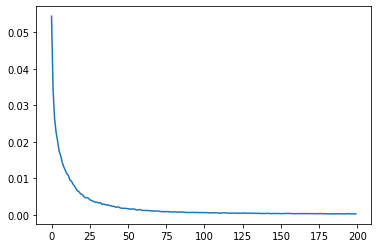

In [427]:
#ploting the loss
model_loss = model.history.history['loss']
plt.plot(range(len(model_loss)), model_loss)

In [428]:
#Predicting using the tuned model
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

In [429]:
#inversing the normalized values 
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[  56.96070546,  -37.67310667,   -6.48357534],
       [ 358.16517591,   30.21983486,  224.81088936],
       [-293.33660096,    4.78704315, -117.87336969],
       [ 378.54348826,  -25.5585857 ,  -23.34461176],
       [ 104.89842981,   15.16586271,  153.60938728]])

In [430]:
#Lets see the predictions (these are the predctions in 2nd order difference)
df_cast = pd.DataFrame(true_predictions, columns=list('ABC'))
df_cast.index = pd.date_range('5/14/2020', periods=5, freq='D')
print(df_cast)

                     A          B           C
2020-05-14   56.960705 -37.673107   -6.483575
2020-05-15  358.165176  30.219835  224.810889
2020-05-16 -293.336601   4.787043 -117.873370
2020-05-17  378.543488 -25.558586  -23.344612
2020-05-18  104.898430  15.165863  153.609387


In [431]:
# Inversing the 2nd order difference

# Add the most recent first difference from the training set to the forecast cumulative sum
df_cast['Cases1d'] = (dataset['Cases'].iloc[-nobs-1]-dataset['Cases'].iloc[-nobs-2]) + df_cast['A'].cumsum()
df_cast['Deaths1d'] = (dataset['Deaths'].iloc[-nobs-1]-dataset['Deaths'].iloc[-nobs-2]) + df_cast['B'].cumsum()
df_cast['Recovered1d'] = (dataset['Recovered'].iloc[-nobs-1]-dataset['Recovered'].iloc[-nobs-2]) + df_cast['C'].cumsum()


# Now build the forecast values from the first difference set
df_cast['CasesForecast'] = dataset['Cases'].iloc[-nobs-1] + df_cast['Cases1d'].cumsum()
df_cast['DeathsForecast'] = dataset['Deaths'].iloc[-nobs-1] + df_cast['Deaths1d'].cumsum()
df_cast['RecoveredForecast'] = dataset['Recovered'].iloc[-nobs-1] + df_cast['Recovered1d'].cumsum()

In [432]:
#Lets now see the Forecast values
df_cast.iloc[:,6:9]

,CasesForecast,DeathsForecast,RecoveredForecast
2020-05-14,81874.960705,2649.326893,28373.516425
2020-05-15,86053.086587,2777.873622,30571.843739
2020-05-16,89937.875867,2911.207393,32652.297683
2020-05-17,94201.208636,3018.982579,34709.407016
2020-05-18,98569.439834,3141.923627,36920.125735


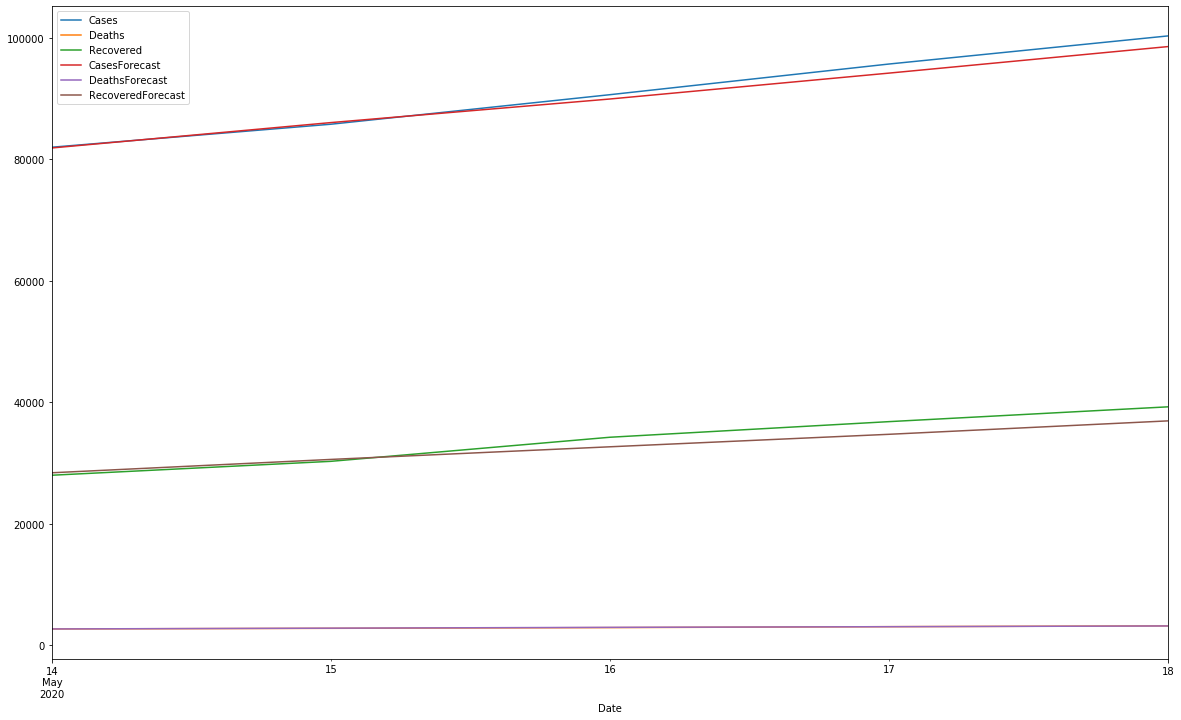

In [433]:
#ploting the forecasted values against actuals

Predict_cases = df_cast.iloc[:,6]
Predict_deaths = df_cast.iloc[:,7]
Predict_recoveries = df_cast.iloc[:,8]

dataset.iloc[-nobs:].plot(figsize = (20,12))
Predict_cases.plot(legend=True)
Predict_deaths.plot(legend=True)
Predict_recoveries.plot(legend=True)


In [434]:
#Evaluating the model
RMSE1 = rmse(dataset.iloc[-nobs:,0], df_cast.iloc[:,6])
RMSE2 = rmse(dataset.iloc[-nobs:,1], df_cast.iloc[:,7])
RMSE3 = rmse(dataset.iloc[-nobs:,2], df_cast.iloc[:,8])

print(f'Cases RMSE: {RMSE1:.3f}')
print(f'Deaths RMSE: {RMSE2:.3f}')
print(f'Recovered RMSE: {RMSE3:.3f}')

Cases RMSE: 1088.531
Deaths RMSE: 22.225
Recovered RMSE: 1576.798
